In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os, shutil

In [2]:
import torch

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Loading, Preprocessing and Augmentation

In [3]:
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd
import os

# Data Augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),                
    transforms.RandomHorizontalFlip(p=0.5),       
    transforms.RandomRotation(degrees=15),        
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),                         
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Define dataset paths
train_folders_all = [
    "../input/C-NMC_Leukemia/training_data/fold_0/all",
    "../input/C-NMC_Leukemia/training_data/fold_1/all",
    "../input/C-NMC_Leukemia/training_data/fold_2/all"
]

train_folders_hem = [
    "../input/C-NMC_Leukemia/training_data/fold_0/hem",
    "../input/C-NMC_Leukemia/training_data/fold_1/hem",
    "../input/C-NMC_Leukemia/training_data/fold_2/hem"
]

val_data_dir = "../input/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data"
val_labels_path = "../input/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv"  # Fixed path

# Custom dataset class for training data
class CombinedDataset(Dataset):
    def __init__(self, folders, label, transform=None):
        self.folders = folders
        self.label = label
        self.transform = transform
        self.image_paths = []

        # Collect all image paths
        for folder in folders:
            for root, _, files in os.walk(folder):
                for file in files:
                    if file.endswith(".bmp"):  
                        self.image_paths.append(os.path.join(root, file))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.label

        if self.transform:
            image = self.transform(image)

        return image, label

# Create ALL and HEM datasets
all_dataset = CombinedDataset(folders=train_folders_all, label=1, transform=transform)
hem_dataset = CombinedDataset(folders=train_folders_hem, label=0, transform=transform)

# Merge ALL and HEM datasets
train_dataset = torch.utils.data.ConcatDataset([all_dataset, hem_dataset])

class LeukemiaValidationDataset(Dataset):
    def __init__(self, img_dir, labels_csv, transform=None):
        self.img_dir = img_dir
        self.transform = transform

        # Load CSV and keep only relevant columns
        self.labels_df = pd.read_csv(labels_csv)

        # Identify correct columns dynamically
        if self.labels_df.shape[1] == 3:  # If 3 columns exist
            self.labels_df = self.labels_df.iloc[:, [1, 2]]  # Use second & third columns
        elif self.labels_df.shape[1] == 2:
            pass  # Already in correct format
        else:
            raise ValueError(f"❌ Unexpected number of columns: {self.labels_df.shape[1]}")

        self.labels_df.columns = ["image_id", "label"]  # Rename columns

        # Convert image IDs to actual filenames
        self.labels_df["image_name"] = self.labels_df["image_id"].astype(str)

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = self.labels_df.iloc[idx]["image_name"]
        img_path = os.path.join(self.img_dir, img_name)

        # Handle missing images
        if not os.path.exists(img_path):
            print(f"❌ Warning: Missing image {img_path}")
            return None

        image = Image.open(img_path).convert("RGB")
        label = self.labels_df.iloc[idx]["label"]

        if self.transform:
            image = self.transform(image)

        return image, label

import torch
from torch.utils.data import Dataset, DataLoader, random_split
train_ratio = 0.8
val_ratio = 0.2


dataset_size = len(train_dataset)
train_size = int(train_ratio * dataset_size)
val_size = dataset_size - train_size # Ensure all samples are used

generator = torch.Generator().manual_seed(42) # For reproducible splits

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size], generator=generator)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)

# Print dataset sizes
print(f"✅ Training dataset size: {len(train_dataset)}")
print(f"✅ Validation dataset size: {len(val_dataset)}")

✅ Training dataset size: 8528
✅ Validation dataset size: 2133


In [4]:
def check_missing_or_corrupt_images(dataset_paths):
    
    missing_images = []
    corrupt_images = []
    
    for folder in dataset_paths:
        for root, _, files in os.walk(folder):
            for file in files:
                img_path = os.path.join(root, file)
                
                # Check if the file exists
                if not os.path.exists(img_path):
                    missing_images.append(img_path)
                    continue
                
                # Try opening the image to check for corruption
                try:
                    with Image.open(img_path) as img:
                        img.verify()  # Verify if the image can be opened
                except (IOError, OSError):
                    corrupt_images.append(img_path)

    # Print results
    if missing_images:
        print("\n Missing Images:")
        for img in missing_images:
            print(img)
    else:
        print("\n No missing images found.")

    if corrupt_images:
        print("\n Corrupt Images:")
        for img in corrupt_images:
            print(img)
    else:
        print("\n No corrupt images found.")

# Define dataset paths (update with actual dataset locations)
dataset_paths = [
    "../input/leukemia-classification/C-NMC_Leukemia/training_data/fold_0/all",
    "../input/leukemia-classification/C-NMC_Leukemia/training_data/fold_1/all",
    "../input/leukemia-classification/C-NMC_Leukemia/training_data/fold_2/all",
    "../input/leukemia-classification/C-NMC_Leukemia/training_data/fold_0/hem",
    "../input/leukemia-classification/C-NMC_Leukemia/training_data/fold_1/hem",
    "../input/leukemia-classification/C-NMC_Leukemia/training_data/fold_2/hem"
]

# Run the check
check_missing_or_corrupt_images(dataset_paths)


 No missing images found.

 No corrupt images found.


## Data Interpretation and Image Results


Displaying sample images from ALL class:


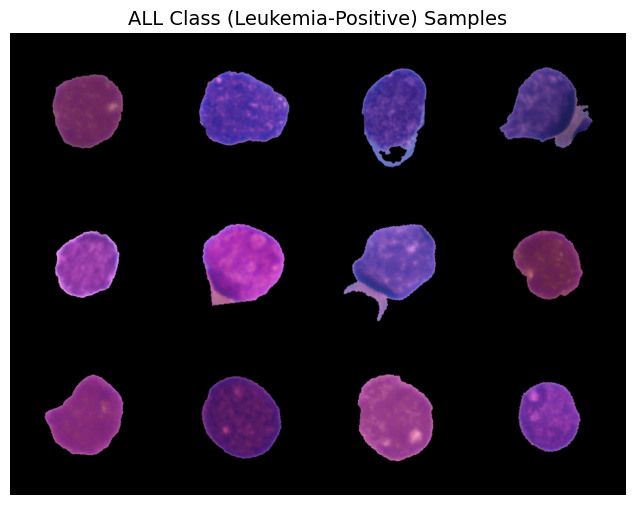

Displaying sample images from HEM class:


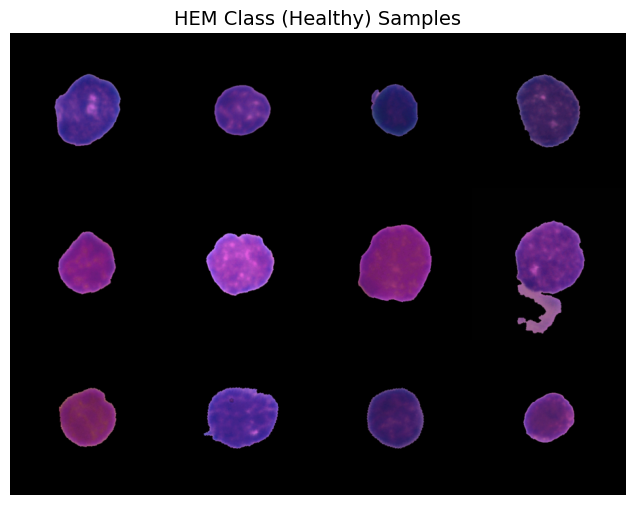

In [5]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torch

# Function to display images from the dataset
def show_sample_images(dataset, num_images=12, title="Sample Images"):
    """
    Displays sample images from a given dataset.
    
    Parameters:
    - dataset: PyTorch Dataset object containing images and labels.
    - num_images: Number of images to display.
    - title: Title of the plot.
    """
    # Select random indices
    indices = torch.randint(0, len(dataset), (num_images,))
    
    # Extract images and labels
    images = [dataset[i][0] for i in indices]  # Extract only the image (not labels)
    labels = [dataset[i][1] for i in indices]  # Extract labels

    # Convert images to a grid
    img_grid = vutils.make_grid(images, nrow=4, normalize=True)

    # Display images
    plt.figure(figsize=(12, 6))
    plt.imshow(img_grid.permute(1, 2, 0))  # Convert tensor to image
    plt.title(title, fontsize=14)
    plt.axis("off")
    plt.show()

# Display samples from ALL class
print("Displaying sample images from ALL class:")
show_sample_images(all_dataset, num_images=12, title="ALL Class (Leukemia-Positive) Samples")

# Display samples from HEM class
print("Displaying sample images from HEM class:")
show_sample_images(hem_dataset, num_images=12, title="HEM Class (Healthy) Samples")

## Custom CvTLeukemia Model

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.checkpoint import checkpoint

class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(in_channels, in_channels // reduction, bias=False)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_channels // reduction, in_channels, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size, channels, _, _ = x.size()
        y = self.global_avg_pool(x).view(batch_size, channels)
        y = self.relu(self.fc1(y))
        y = self.sigmoid(self.fc2(y)).view(batch_size, channels, 1, 1)
        return x * y


class ConvolutionalTokenEmbedding(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, 1, 0)
        self.layer_norm = nn.LayerNorm(out_channels)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        b, c, h, w = x.size()
        x = x.permute(0, 2, 3, 1).reshape(b, h * w, c)
        x = self.layer_norm(x)
        return x, h, w


class SparseSelfAttention(nn.Module):
    def __init__(self, dim, num_heads=4, window_size=32):
        super().__init__()
        self.num_heads = num_heads
        self.window_size = window_size
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = nn.Linear(dim, dim * 3)
        self.proj = nn.Linear(dim, dim)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        q = q.contiguous().view(B, self.num_heads, N // self.window_size, self.window_size, -1)
        k = k.contiguous().view(B, self.num_heads, N // self.window_size, self.window_size, -1)
        v = v.contiguous().view(B, self.num_heads, N // self.window_size, self.window_size, -1)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = F.softmax(attn, dim=-1)
        x = (attn @ v).reshape(B, N, C)
        x = self.proj(x)
        return x


class ConvolutionalTransformerBlock(nn.Module):
    def __init__(self, dim, mlp_ratio=2.0, window_size=32):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = SparseSelfAttention(dim, window_size=window_size)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.GELU(),
            nn.Linear(int(dim * mlp_ratio), dim),
        )

    def _attn_block(self, x):
        return self.attn(x)
    
    def _mlp_block(self, x):
        return self.mlp(x)
    
    def forward(self, x):
        x = x + checkpoint(self._attn_block, self.norm1(x))
        x = x + checkpoint(self._mlp_block, self.norm2(x))
        return x


class DropBlock2D(nn.Module):
    def __init__(self, block_size=3, drop_prob=0.1):
        super(DropBlock2D, self).__init__()
        self.block_size = block_size
        self.drop_prob = drop_prob

    def forward(self, x):
        if not self.training or self.drop_prob == 0:
            return x
        
        gamma = self.drop_prob / (self.block_size ** 2)
        mask = (torch.rand(x.shape[0], 1, x.shape[2], x.shape[3], device=x.device) < gamma).float()
        mask = F.max_pool2d(mask, kernel_size=(self.block_size, self.block_size), stride=(1, 1), padding=self.block_size // 2)
        mask = 1 - mask  # Invert mask to keep certain regions
        x = x * mask * (mask.numel() / mask.sum())  # Scale values
        return x


class LeukemiaCvTModel(nn.Module):
    def __init__(self, in_channels=3, num_classes=2):
        super().__init__()

        # Stage 1
        self.stage1_embed = ConvolutionalTokenEmbedding(in_channels, 32, kernel_size=7, stride=1, padding=3)
        self.stage1_transformer = ConvolutionalTransformerBlock(32, window_size=32)
        self.se1 = SEBlock(32)
        self.dropblock1 = DropBlock2D(block_size=3, drop_prob=0.1)  # DropBlock added

        # Stage 2
        self.stage2_embed = ConvolutionalTokenEmbedding(32, 96, kernel_size=3, stride=2, padding=1)
        self.stage2_transformer = ConvolutionalTransformerBlock(96, window_size=32)
        self.se2 = SEBlock(96)
        self.dropblock2 = DropBlock2D(block_size=3, drop_prob=0.1)  # DropBlock added

        # Stage 3
        self.stage3_embed = ConvolutionalTokenEmbedding(96, 192, kernel_size=3, stride=4, padding=1)
        self.stage3_transformer = ConvolutionalTransformerBlock(192, window_size=14)
        self.se3 = SEBlock(192)
        self.dropblock3 = DropBlock2D(block_size=3, drop_prob=0.1)  # DropBlock added
        
        # Classification Head
        self.head = nn.Sequential(
            nn.LayerNorm(192),
            nn.Linear(192, num_classes),
        )

    def forward(self, x):
        # Stage 1
        b, c, h, w = x.size()
        x1, h1, w1 = self.stage1_embed(x)
        x1 = self.stage1_transformer(x1)
        x1 = x1.permute(0, 2, 1).reshape(b, 32, h1, w1)
        x1 = self.se1(x1)
        x1 = self.dropblock1(x1)  # Applying DropBlock

        # Stage 2
        x2, h2, w2 = self.stage2_embed(x1)
        x2 = self.stage2_transformer(x2)
        x2 = x2.permute(0, 2, 1).reshape(b, 96, h2, w2)
        x2 = self.se2(x2)
        x2 = self.dropblock2(x2)  # Applying DropBlock

        # Stage 3
        x3, h3, w3 = self.stage3_embed(x2)
        x3 = self.stage3_transformer(x3)
        x3 = x3.permute(0, 2, 1).reshape(b, 192, h3, w3)
        x3 = self.se3(x3)
        x3 = self.dropblock3(x3)  # Applying DropBlock

        # Classification
        x3 = x3.mean(dim=(2, 3))
        x3 = self.head(x3)
        return x3


In [7]:
import torch
import torch.nn as nn

class MambaBlock(nn.Module):
    def __init__(self, in_channels, state_size, expansion_factor):
        super().__init__()
        self.linear_in = nn.Linear(in_channels, in_channels * expansion_factor)
        self.ssm = nn.Linear(in_channels * expansion_factor, state_size)
        self.linear_out = nn.Linear(state_size, in_channels)
        self.activation = nn.SiLU()

    def forward(self, x):
        # Assuming input x is (batch_size, sequence_length, in_channels)
        x = self.linear_in(x)
        x = self.activation(x)
        x = self.ssm(x)
        x = self.linear_out(x)
        return x

class LeukemiaCvTModel2(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        # Example: Simplified convolutional token embedding
        self.conv_embed = nn.Conv2d(3, 64, kernel_size=7, stride=4, padding=2)

        # Assuming input 224x224 -> Output 56x56. Seq_len = 56*56 = 3136. Embed_dim = 64.
        embed_dim = 64
        transformer_dim = 256 # Define the dimension for the transformer/mamba stages

        # Corrected Transformer stage
        self.transformer_stage1 = nn.Sequential(
            # Corrected Linear layer to accept embed_dim (64)
            nn.Linear(embed_dim, transformer_dim),
            nn.LayerNorm(transformer_dim),
            # Added batch_first=True
            nn.TransformerEncoderLayer(d_model=transformer_dim, nhead=8, batch_first=True)
        )

        # Integrate Mamba blocks in later stages
        self.mamba_stage1 = nn.Sequential(
            # Input to MambaBlock is now transformer_dim (256)
            MambaBlock(in_channels=transformer_dim, state_size=512, expansion_factor=2),
            MambaBlock(in_channels=transformer_dim, state_size=512, expansion_factor=2)
        )

        self.global_pool = nn.AdaptiveAvgPool1d(1)
        # Classifier input should match the output dim (transformer_dim)
        self.classifier = nn.Linear(transformer_dim, num_classes)

    def forward(self, x):
        x = self.conv_embed(x) # (N, 64, 56, 56)
        # Flatten H, W and transpose: (N, 64, 3136) -> (N, 3136, 64)
        x = x.flatten(2).transpose(1, 2)
        x = self.transformer_stage1(x) # (N, 3136, 256)
        x = self.mamba_stage1(x)       # (N, 3136, 256)
        # Transpose back for pooling: (N, 256, 3136)
        x = x.transpose(1, 2)
        x = self.global_pool(x)       # (N, 256, 1)
        x = x.flatten(1)              # (N, 256)
        x = self.classifier(x)        # (N, num_classes)
        return x

In [8]:
from torch.cuda.amp import GradScaler, autocast
import torch.optim as optim
import time

def modelFitter(train_loader, val_loader, epochs=10, lr=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Initialize model with reduced parameters
    model = LeukemiaCvTModel()
    model = model.to(device)
    
    # Optimizer with weight decay
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, 
                                            epochs=epochs,
                                            steps_per_epoch=len(train_loader))
    
    # Loss function
    criterion = nn.CrossEntropyLoss()
    scaler = GradScaler()
    
    # For tracking metrics
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(epochs):
        start_time = time.time()
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            # Mixed precision training
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            # Gradient accumulation
            scaler.scale(loss).backward()
            
            # Update weights
            if (batch_idx + 1) % 4 == 0 or (batch_idx + 1) == len(train_loader):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                scheduler.step()
            
            # Calculate metrics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        # Training metrics
        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        
        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100 * val_correct / val_total
        
        # Store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Print epoch summary
        epoch_time = time.time() - start_time
        lr_current = scheduler.get_last_lr()[0]
        print(f"Epoch {epoch+1}/{epochs} | Time: {epoch_time:.2f}s")
        print(f"LR: {lr_current:.2e} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        print('-' * 50)
    
    # Final summary
    best_val_acc = max(history['val_acc'])
    print(f"\nTraining Complete")
    print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
    
    return model, history

## Fit Function

In [9]:
# Assuming you have prepared DataLoaders:
# train_loader and val_loader

model, history = modelFitter(
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=30,
    lr=1e-4
)

Using device: cuda


/tmp/ipykernel_19/1068845821.py:23: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_19/1068845821.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch

Epoch 1/30 | Time: 239.72s
LR: 4.18e-06 | Train Loss: 0.8980 | Train Acc: 46.20%
Val Loss: 0.6267 | Val Acc: 68.21%
--------------------------------------------------
Epoch 2/30 | Time: 234.17s
LR: 4.73e-06 | Train Loss: 0.6257 | Train Acc: 68.21%
Val Loss: 0.6264 | Val Acc: 68.21%
--------------------------------------------------
Epoch 3/30 | Time: 234.19s
LR: 5.64e-06 | Train Loss: 0.6254 | Train Acc: 68.21%
Val Loss: 0.6252 | Val Acc: 68.21%
--------------------------------------------------
Epoch 4/30 | Time: 234.18s
LR: 6.91e-06 | Train Loss: 0.6254 | Train Acc: 68.21%
Val Loss: 0.6248 | Val Acc: 68.21%
--------------------------------------------------
Epoch 5/30 | Time: 234.23s
LR: 8.51e-06 | Train Loss: 0.6251 | Train Acc: 68.21%
Val Loss: 0.6242 | Val Acc: 68.21%
--------------------------------------------------
Epoch 6/30 | Time: 234.23s
LR: 1.05e-05 | Train Loss: 0.6242 | Train Acc: 68.21%
Val Loss: 0.6258 | Val Acc: 68.21%
-------------------------------------------------

In [10]:
torch.save(model.state_dict(), 'model_weights.pth')

## Metrics and Accuracy

/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


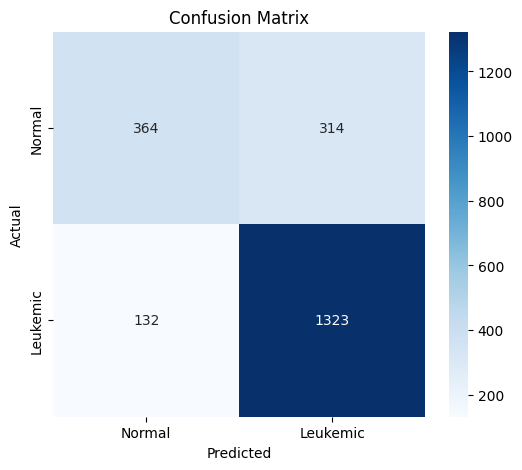

Precision: 0.7846
Accuracy: 0.7909
F1 Score: 0.7809


In [11]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, f1_score

# Function to evaluate model and get predictions
def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Compute and display metrics
def compute_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted')  # Weighted precision
    accuracy = accuracy_score(y_true, y_pred)  # Overall accuracy
    f1 = f1_score(y_true, y_pred, average='weighted')  # Weighted F1-score
    
    print(f'Precision: {precision:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'F1 Score: {f1:.4f}')
    
    return precision, accuracy, f1

# Assuming 'val_loader' is your validation data loader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get predictions and actual labels
y_pred, y_true = evaluate_model(model, val_loader, device)

# Define class names (0: Normal, 1: Leukemic)
class_names = ['Normal', 'Leukemic']

# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred, class_names)

# Compute and print performance metrics
precision, accuracy, f1 = compute_metrics(y_true, y_pred)


## GPU and Memory check-up

In [12]:
torch.cuda.empty_cache()

In [13]:
def print_gpu_memory():
    print(f"Allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
    print(f"Reserved: {torch.cuda.memory_reserved() / 1e9:.2f} GB")

print_gpu_memory()

Allocated: 0.02 GB
Reserved: 0.05 GB


In [14]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  18257 KiB |   1071 MiB | 252598 GiB | 252598 GiB |
|       from large pool |  16640 KiB |   1064 MiB | 251175 GiB | 251175 GiB |
|       from small pool |   1617 KiB |     11 MiB |   1422 GiB |   1422 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  18257 KiB |   1071 MiB | 252598 GiB | 252598 GiB |
|       from large pool |  16640 KiB |   1064 MiB | 251175 GiB |

In [15]:
import gc

def reset_memory():
    # Delete all variables.
    for var in gc.get_objects():
        try:
            del var
        except:
            pass

    # Run the garbage collector.
    gc.collect()

    print("Memory has been reset")

# Call the function to reset memory.
reset_memory()

Memory has been reset


In [16]:
   import gc

   gc.collect()


0